In [4]:
import joblib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Load Preprocessor

In [6]:
preprocessor = joblib.load("preprocessor.joblib")
X_train, X_test, y_train, y_test = joblib.load("splits.joblib")

# Logistic Regression (Baseline model)

In [10]:
from sklearn.linear_model import LogisticRegression
# Transform data using the preprocessor
X_train_pre = preprocessor.transform(X_train)
X_test_pre  = preprocessor.transform(X_test)

# Train Logistic Regression with class weighting (handle imbalance)
logit = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
logit.fit(X_train_pre, y_train)

# Evaluate
y_pred  = logit.predict(X_test_pre)
y_proba = logit.predict_proba(X_test_pre)[:, 1]

print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(classification_report(y_test, y_pred, digits=3))

ROC AUC: 0.731
              precision    recall  f1-score   support

           0      0.922     0.664     0.772      1801
           1      0.272     0.691     0.390       327

    accuracy                          0.668      2128
   macro avg      0.597     0.678     0.581      2128
weighted avg      0.822     0.668     0.713      2128



# RandomForest model

ROC AUC: 0.9561499133169306
              precision    recall  f1-score   support

           0      0.918     0.997     0.956      1801
           1      0.965     0.508     0.665       327

    accuracy                          0.922      2128
   macro avg      0.941     0.752     0.810      2128
weighted avg      0.925     0.922     0.911      2128



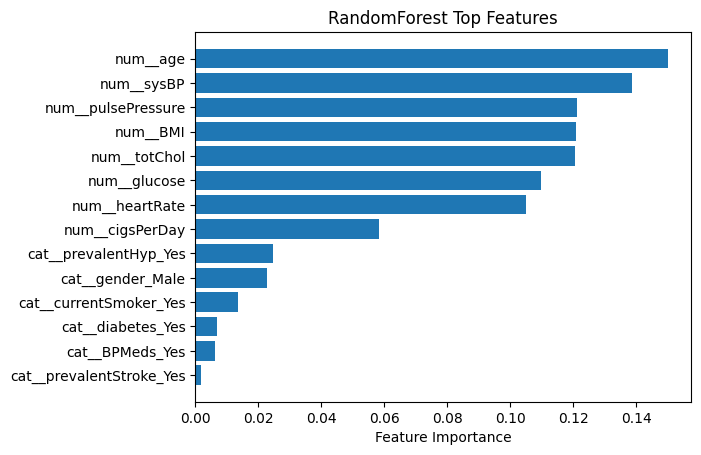

In [12]:
# Pipeline: preprocessor + RandomForest
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,       # number of trees
        max_depth=None,         # let it grow deep (tune later)
        random_state=42,
        class_weight="balanced" # handle imbalance
    ))
])

# Train
rf_clf.fit(X_train, y_train)

# Predict
y_pred = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)[:, 1]

# Evaluate
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

# Feature importance
import matplotlib.pyplot as plt
import numpy as np

importances = rf_clf.named_steps["classifier"].feature_importances_
feat_names = rf_clf.named_steps["preprocessor"].get_feature_names_out()

indices = np.argsort(importances)[::-1][:15]
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [feat_names[i] for i in indices][::-1])
plt.xlabel("Feature Importance")
plt.title("RandomForest Top Features")
plt.show()

## RandomForest model with lower threshold (0.3)

In [13]:
from sklearn.metrics import precision_recall_curve

y_proba = rf_clf.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Example: use threshold 0.3
y_pred_thresh = (y_proba >= 0.3).astype(int)
print(classification_report(y_test, y_pred_thresh, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0      0.958     0.972     0.965      1801
           1      0.831     0.765     0.796       327

    accuracy                          0.940      2128
   macro avg      0.894     0.868     0.880      2128
weighted avg      0.938     0.940     0.939      2128

ROC AUC: 0.9561499133169306


## ROC curves and confusion matrix for the Random Forest model

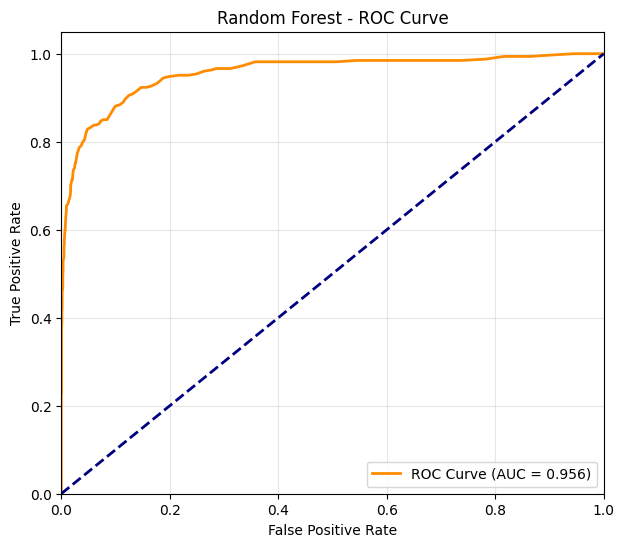

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class
y_proba = rf_clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

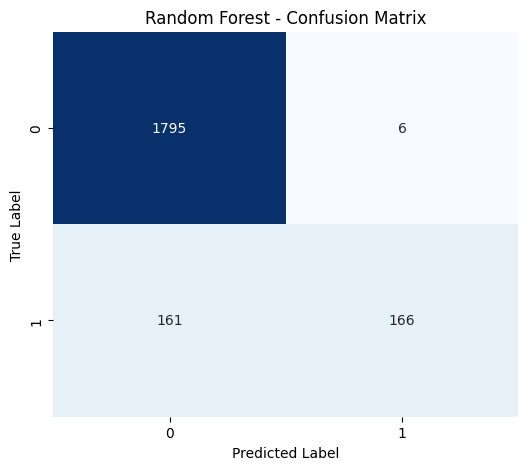

## Preprocessing pipline + Random forest model save

In [16]:
joblib.dump(rf_clf, "heart_rf_pipeline.pkl")

['heart_rf_pipeline.pkl']

# MLPClassifier Model

In [16]:
import joblib
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report

# Load artifacts you already saved
preprocessor = joblib.load("preprocessor.joblib")
X_train, X_test, y_train, y_test = joblib.load("splits.joblib")

# Class weights to handle imbalance (passed as sample weights)
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cw_map = {0: cw[0], 1: cw[1]}
sample_weight = np.where(y_train == 1, cw_map[1], cw_map[0])

# Pipeline: preprocessor + MLP
mlp_sklearn = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        alpha=1e-4,            # L2 regularization
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=300,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42,
        verbose=True           # prints epochs
    ))
])

# Fit (note: pass sample_weight into the clf step)
mlp_sklearn.fit(X_train, y_train, clf__sample_weight=sample_weight)

# Evaluate
y_proba = mlp_sklearn.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print("Sklearn MLP ROC AUC:", auc)

# Choose threshold by maximizing F1
prec, rec, thr = precision_recall_curve(y_test, y_proba)
thr = np.r_[0, thr]
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1)
best_thr = float(thr[best_idx])
print(f"Best F1 threshold: {best_thr:.2f} (P={prec[best_idx]:.3f}, R={rec[best_idx]:.3f})")

y_pred = (y_proba >= best_thr).astype(int)
print(classification_report(y_test, y_pred, digits=3))

Iteration 1, loss = 0.64362280
Validation score: 0.662067
Iteration 2, loss = 0.61101362
Validation score: 0.649957
Iteration 3, loss = 0.60108738
Validation score: 0.665196
Iteration 4, loss = 0.59551535
Validation score: 0.657577
Iteration 5, loss = 0.58951793
Validation score: 0.656907
Iteration 6, loss = 0.58635909
Validation score: 0.654806
Iteration 7, loss = 0.57973414
Validation score: 0.660036
Iteration 8, loss = 0.57702081
Validation score: 0.654067
Iteration 9, loss = 0.57272131
Validation score: 0.666628
Iteration 10, loss = 0.56776378
Validation score: 0.658915
Iteration 11, loss = 0.56306869
Validation score: 0.664215
Iteration 12, loss = 0.55741707
Validation score: 0.670402
Iteration 13, loss = 0.55353418
Validation score: 0.673936
Iteration 14, loss = 0.54760928
Validation score: 0.682512
Iteration 15, loss = 0.54479903
Validation score: 0.684972
Iteration 16, loss = 0.53922998
Validation score: 0.684209
Iteration 17, loss = 0.53600184
Validation score: 0.684637
Iterat

## Xgboost model

In [17]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report

# Compute scale_pos_weight on the original training labels
neg, pos = np.bincount(y_train)
spw = neg / pos

xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgb", XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        random_state=42,
        scale_pos_weight=spw
    ))
])

xgb_pipe.fit(X_train, y_train)
y_proba = xgb_pipe.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.4).astype(int)

print("XGBoost (Pipeline) ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

XGBoost (Pipeline) ROC AUC: 0.8574645074856476
              precision    recall  f1-score   support

           0      0.955     0.739     0.833      1801
           1      0.361     0.810     0.499       327

    accuracy                          0.750      2128
   macro avg      0.658     0.775     0.666      2128
weighted avg      0.864     0.750     0.782      2128

